# Predicting Bike Rentals
The data used in this project is a collection of detailed data on the number of bicycles people rent by the hour and day in Washington, D.C. The data includes details like the weather conditions as well calendaric information. These features will be important in the multiple models used to predict the total number of bikes people rented in a given hour.
## Part I - Introduction
**Explore the data** 

In [1]:
import pandas as pd
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


**Use a histogram to investigate distribution of total rentals**

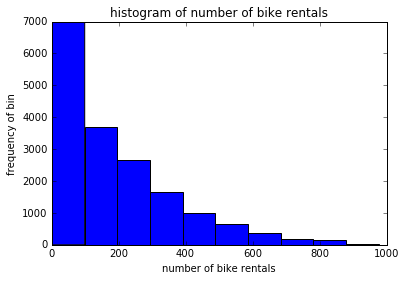

In [2]:
% matplotlib inline
import matplotlib.pyplot as plt
plt.hist(bike_rentals['cnt'])
plt.title('histogram of number of bike rentals')
plt.xlabel('number of bike rentals')
plt.ylabel('frequency of bin')

**Explore the correlation with the features and target column** <br>
Note: registered (number of registered riders) and casual (number of casual riders who hadn't previousl signed up with the bike sharing program) will not be used as feature columns as they are addends, or summands, cnt (the total number of bike rentals) - common not to use features that the target is derived from.

In [3]:
bike_rentals.corr()['cnt'].sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

## Part II - Calculating Features
It can often be helpful to calculate features before applying machine learning models. Features can enhanve the accuracy of models by introducing new information, or distilling existing information.

For example the hr column is the hours during which bikes are rented, from 1 to 24. To make the computer understand the relation between them. may be better to add a new column with labels for morning, afternoon, evening and night. Bundling similar times together will enable the model to make better decisions.

**Define a function that bundles hours together**

In [4]:
def assign_label(num_val_for_hr):
    if 6 <= num_val_for_hr < 12:
        return 1
    elif 12 <= num_val_for_hr < 18:
        return 2
    elif 18 <= num_val_for_hr <= 24:
        return 3
    elif 0 <= num_val_for_hr < 6:
        return 4

**apply function to each item in the hour column**

In [5]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
#bike_rentals[['hr','time_label']].head(24)
bike_rentals['time_label'].value_counts(ascending=False)

2    4375
3    4368
1    4360
4    4276
Name: time_label, dtype: int64

## Part III - Splitting the Data Into Train and Test Sets
Important to split data because if the algorithm is trained and evaluated on the same data, it is possible to get an unrealistically low error value, due to overfitting.

**Based on explorations of the cnt (count) column, explain which error metric is best to evaluate the performance of the machine learning algorithms and why** <br>
two possible error metrics are mean squared error (MSE) and [area under the curve (AUC) of a Receiver Operator Characteristic (ROC) curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
- MSE would take the sum of the squared differences between the predicted and actual values
- [AUC](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) would measure [the ability of a classifier to distinguish between classes](https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/#:~:text=The%20Area%20Under%20the%20Curve,the%20positive%20and%20negative%20classes.)
- Other resources for AUC ROC:
    - [ROC Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
    - [scikit learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)
    - [displaying](https://www.displayr.com/what-is-a-roc-curve-how-to-interpret-it/)
    - [example](https://intellipaat.com/blog/roc-curve-in-machine-learning/)
    - [more](https://stackabuse.com/understanding-roc-curves-with-python/)
    
- Here MSE will be chosen over AUC because MSE is [typically used for regression and AUC for classification](https://medium.com/usf-msds/choosing-the-right-metric-for-evaluating-machine-learning-models-part-2-86d5649a5428) and this is a linear regression problem

In [6]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 18 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
time_label    17379 non-null int64
dtypes: float64(4), int64(13), object(1)
memory usage: 2.4+ MB


**Selecting training set and testing set**

In [7]:
train = bike_rentals.sample(frac=0.8)
test = bike_rentals.iloc[~bike_rentals.index.isin(train.index)]

## Part IV - Applying Linear Regression
- Linear regression will probably work fairly well on this data, given that many of the columns are highly correlated with the target column
- Linear regression works best when predictors are linearly correlated to the target and also independent - in other words, they don't change meaning when we combine them with each other
- The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward
- However it could be prone to underfitting the data and not building a powerful enough model
- This means that linear regression usually isn't the most accurate option

**Select predictor columns**

In [8]:
features = bike_rentals.columns.drop(['cnt','casual','dteday','registered'])
features1 = features.drop(['windspeed','workingday','weekday','holiday'])
features2 = features1.drop(['season','mnth','weathersit'])

In [9]:
bike_rentals.corr()['cnt'][features1].sort_values(ascending=False)

temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
weathersit   -0.142426
hum          -0.322911
time_label   -0.378318
Name: cnt, dtype: float64

**Use the LinearRegression class from sklearn to train and predict**

In [10]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr_pred = lr.fit(train[features],train['cnt']).predict(test[features])
lr_pred1 = lr.fit(train[features1],train['cnt']).predict(test[features1])
lr_pred2 = lr.fit(train[features2],train['cnt']).predict(test[features2])

**Evaluate error between the predictions and the actual values**

In [11]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test['cnt'],lr_pred)
mse1 = mean_squared_error(test['cnt'],lr_pred1)
mse2 = mean_squared_error(test['cnt'],lr_pred2)

print('MSE when features are: {0}'.format(features),round(mse),'\n')
print('MSE when features are: {0}'.format(features1),round(mse1),'\n')
print('MSE when features are: {0}'.format(features2),round(mse2))

MSE when features are: Index(['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'time_label'],
      dtype='object') 17614.0 

MSE when features are: Index(['instant', 'season', 'yr', 'mnth', 'hr', 'weathersit', 'temp', 'atemp',
       'hum', 'time_label'],
      dtype='object') 17630.0 

MSE when features are: Index(['instant', 'yr', 'hr', 'temp', 'atemp', 'hum', 'time_label'], dtype='object') 17808.0


**Analysis of the eror**
- mse - The error when the feature columns only discludes non-numeric columns ("dteday" - the date), the target column ("cnt" - the bike count) and columns the target column are derived form ("casual" and "registered")
- mse1 - are the featuers in mse minus the holiday, weekday, workingday and windspeed columns
- mse2 - are the features in mse1 minus the season, month and weathersit columns

## Part V - Applying Decision Trees
- Compare the error from decision trees and the error from linear regression as a tool to pick the right algorithm for this data
- Decision trees tend to predict outcomes much more reliably than linear regression models 
- Becuse a decision tree is a fairly complex model, it also tends to overfit, particularly when the parameters like maximum depth and minimum number of samples per leaf are not tweaked
- Decision trees are also prone to instability - small changes in the input data can result in a vert differen output model

**Use DecisionTreeRegressor to fit, predict and calculate the error**

In [12]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
dt.fit(train[features],train['cnt'])
dt_pred = dt.predict(test[features])
dt_mse = mean_squared_error(test['cnt'],dt_pred)
print('Decision tree mse: ',round(dt_mse))

Decision tree mse:  2968.0


**Experiment with various parameters of the DecisionTreeRegressor class and evaluate the error to see if it changes**

In [36]:
#for i in range(1,20):
dt1 = DecisionTreeRegressor(min_samples_leaf = 5) #max_depth
dt1.fit(train[features],train['cnt'])
dt_pred1 = dt1.predict(test[features])
dt1_mse = mean_squared_error(test['cnt'],dt_pred1)
print('Decision tree mse: ',round(dt1_mse))

Decision tree mse:  2710.0


**Discoveries on the predictions and error**
- The nonlinear predictor - the decision tree regressor - has a order of magnitude smaller error than the linear regressor
- Creating a minimum number of samples for each leaf decreased the error metric indicating that parameter tweaking could potentially optimize error

## Part VI - Applying Random Forests
- Applying the random forest algorithm will improve the decision tree algorithm
- Random forests tend to be much more accurate than simple models like linear regression
- Due to the way random forests are constructed, they tend to overfit much less than decision trees
- Random forests can still be prone to overfitting thoughm so it's important to tune parameters like maximum depth and minimum samples per leaf

**Use the RandomForestRegressor class to fit, predict and calculate the error**

In [38]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(train[features],train['cnt'])
rf_pred = rf.predict(test[features])
rf_mse = mean_squared_error(test['cnt'],rf_pred)
print('Random forest mse: ',round(rf_mse))

Random forest mse:  1729.0


**Experiment with various parameters of the RandomForestRegressor class and evaluate the error to see if it changes**

In [39]:
rf1 = RandomForestRegressor(min_samples_leaf = 5) #max_depth
rf1.fit(train[features],train['cnt'])
rf_pred1 = rf1.predict(test[features])
rf1_mse = mean_squared_error(test['cnt'],rf_pred1)
print('Random forest mse: ',round(rf1_mse))

Random forest mse:  1817.0


** Findings on applying Random Forests**
- Applying Random Forests decreases the error metric from the use Decision Trees, however implementing minimum number of samples in each leaf did not seem to improve the mse. Perhaps parameter tweaking is small in comparison to the impact of using a random forest instead of a decision trees.

## Part VII - Next Steps
- Potential next steps include:
    - Calculating additional features, such as: 
        - An index combining temperature, humidity and wind speed
    - Try predicting "casual" and "registered" instead of "cnt"